In [36]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.9.1


In [81]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# Load the data

In [83]:
filenames = tf.io.gfile.glob(str('C:/Users/Rugved Chavan/Desktop/GAIP Project/archive/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('C:/Users/Rugved Chavan/Desktop/GAIP Project/archive/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [84]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [85]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Rugved Chavan\\Desktop\\GAIP Project\\archive\\chest_xray\\train\\NORMAL\\NORMAL2-IM-1094-0001-0002.jpeg'
b'C:\\Users\\Rugved Chavan\\Desktop\\GAIP Project\\archive\\chest_xray\\train\\NORMAL\\IM-0370-0001.jpeg'
b'C:\\Users\\Rugved Chavan\\Desktop\\GAIP Project\\archive\\chest_xray\\train\\PNEUMONIA\\person1159_virus_1945.jpeg'
b'C:\\Users\\Rugved Chavan\\Desktop\\GAIP Project\\archive\\chest_xray\\train\\PNEUMONIA\\person1484_virus_2576.jpeg'
b'C:\\Users\\Rugved Chavan\\Desktop\\GAIP Project\\archive\\chest_xray\\train\\PNEUMONIA\\person810_virus_1446.jpeg'


In [86]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [87]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

NameError: name 'GCS_PATH' is not defined

In [88]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [89]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [90]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [91]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)

# visualize the shape of an (image, label) pair.

In [71]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [104]:
test_list_ds = tf.data.Dataset.list_files(str('C:/Users/Rugved Chavan/Desktop/GAIP Project/archive/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

16

# Visualize the dataset

In [73]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [74]:
val_ours = val_ds

In [75]:
val_ours

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>

In [76]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [77]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

IndexError: index 16 is out of bounds for axis 0 with size 16

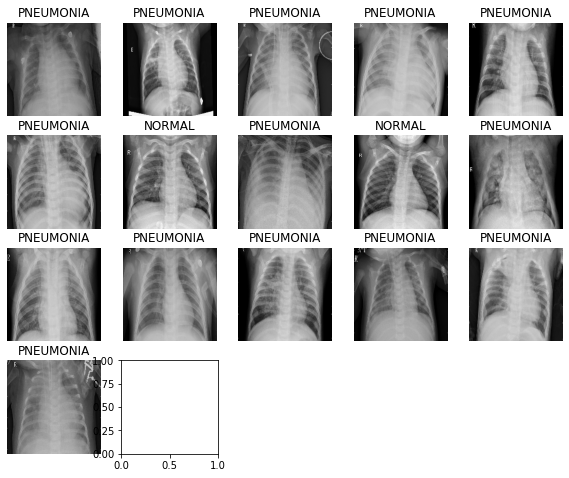

In [78]:
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN Model

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.0685705])

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


# Train the model

In [24]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=5,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/5
261/261 [==============================] - 15s 58ms/step - loss: 0.2077 - accuracy: 0.9212 - precision: 0.9770 - recall: 0.9157 - val_loss: 0.6300 - val_accuracy: 0.7375 - val_precision: 0.7360 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 15s 58ms/step - loss: 0.1754 - accuracy: 0.9337 - precision: 0.9784 - recall: 0.9315 - val_loss: 0.0887 - val_accuracy: 0.9683 - val_precision: 0.9828 - val_recall: 0.9738
Epoch 3/5
261/261 [==============================] - 15s 58ms/step - loss: 0.1705 - accuracy: 0.9351 - precision: 0.9791 - recall: 0.9328 - val_loss: 0.1721 - val_accuracy: 0.9308 - val_precision: 0.9943 - val_recall: 0.9110
Epoch 4/5
261/261 [==============================] - 15s 57ms/step - loss: 0.1496 - accuracy: 0.9437 - precision: 0.9816 - recall: 0.9421 - val_loss: 0.0933 - val_accuracy: 0.9644 - val_precision: 0.9827 - val_recall: 0.9686
Epoch 5/5
261/261 [==============================] - 15s 58ms/step - loss: 0.1393 - accuracy: 0.9466

In [ ]:
model.save('Models/NewCNN_xray_model.h5')

#  Finetune the model

In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn_upload.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [28]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [29]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
261/261 [==============================] - 16s 59ms/step - loss: 0.3413 - accuracy: 0.8587 - precision: 0.9533 - recall: 0.8522 - val_loss: 10.3172 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/100
261/261 [==============================] - 15s 58ms/step - loss: 0.2467 - accuracy: 0.9018 - precision: 0.9713 - recall: 0.8944 - val_loss: 0.1703 - val_accuracy: 0.9288 - val_precision: 0.9845 - val_recall: 0.9174 - lr: 0.0089
Epoch 3/100
261/261 [==============================] - 15s 57ms/step - loss: 0.2082 - accuracy: 0.9169 - precision: 0.9762 - recall: 0.9104 - val_loss: 1.5368 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000 - lr: 0.0079
Epoch 4/100
261/261 [==============================] - 15s 58ms/step - loss: 0.2119 - accuracy: 0.9183 - precision: 0.9753 - recall: 0.9136 - val_loss: 1.9943 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000 - lr: 0.0071
Epoch 5/100
261/261 [==========

# Visualizing model performance Metrics

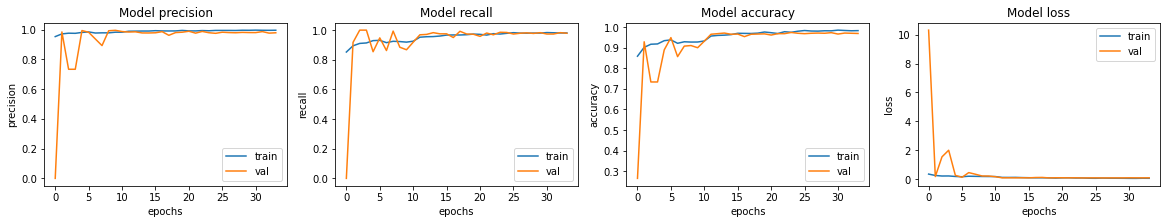

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Predict and evaluate results

In [106]:
loss, acc, prec, rec = model.evaluate(test_ds)

1/1 [==============================] - 0s 132ms/step - loss: 0.2109 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8750


In [93]:
loss, acc, prec, rec = model.evaluate(val_ds)

66/66 [==============================] - 3s 36ms/step - loss: 0.0363 - accuracy: 0.9895 - precision: 0.9974 - recall: 0.9885


In [187]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         'C:/Users/Rugved Chavan/Desktop/GAIP Project/cleaned_data_copy/split_data/train',
#     class_mode='binary',
#         target_size=(128, 128), batch_size= 32)

validation_generator = test_datagen.flow_from_directory(
        'C:/Users/Rugved Chavan/Desktop/GAIP Project/archive/chest_xray/chest_xray/train',class_mode='binary',
        target_size=(180, 180),shuffle='False',batch_size=1040)

Found 5216 images belonging to 2 classes.


In [188]:
x_val , y_val = next(validation_generator)

In [189]:
len(x_val)

1040

In [190]:
y_val

array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)

In [191]:
preds = model.predict(x_val)

33/33 [==============================] - 0s 11ms/step


In [192]:
preds

array([[0.9996207 ],
       [0.933748  ],
       [0.00252322],
       ...,
       [0.9880334 ],
       [0.99951625],
       [0.9769032 ]], dtype=float32)

In [193]:
print(confusion_matrix(y_val, preds.round()))

[[252   4]
 [  6 778]]


Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

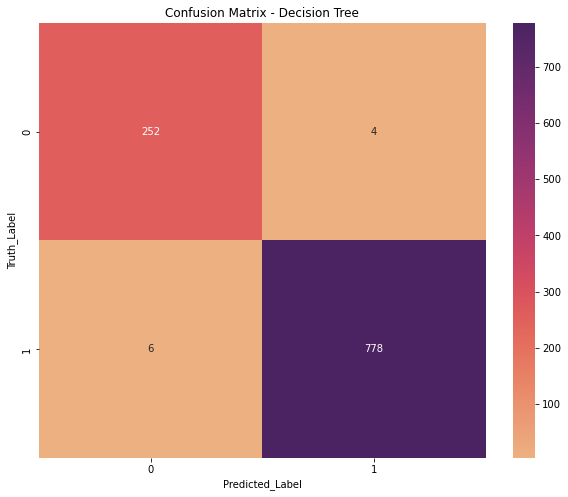

In [194]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, preds.round())
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')
plt.title('Confusion Matrix - Decision Tree')